- NASA数据集，b0005, b0006, b0007
- 时间序列输入

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary

Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 268 ('font.family         : sans-serif        ')
Duplicate key in file PosixPath('/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/matplotlib/mpl-data/matplotlibrc'), line 272 ('font.sans-serif: DejaVu Sans, Bitstream Vera Sans, Computer Modern Sans Serif, Lucida Grande, Verdana, Geneva, Lucid, Arial, Helvetica, Avant Garde, sans-serif')


In [2]:
%matplotlib inline

In [3]:
def feature_label_generator(raw_data, window_size=16):
    """
    description:
        输入时间序列，根据时间系列生成样本（特征和标签）
    parameters:
        raw_data: 原始时间序列
        Window_size: 滑动窗口长度
    returns:
        features: 生成的特征集合
        labels: 生成的标签集合
    """
    raw_data = np.array(raw_data) if type(raw_data) is not np.ndarray else raw_data
    # features, labels = [], []
    sample = []
    # for i in range(len(raw_data) - window_size):
    #     features.append(raw_data[i:i + window_size])
    #     labels.append(raw_data[i + window_size])
    # return features, labels
    for i in range(len(raw_data) - window_size):
        sample.append((raw_data[i:i + window_size], raw_data[i + window_size]))
    return sample

# test_raw_data = np.array(range(10))
# features, labels = feature_label_generator(test_raw_data, window_size=3)
# print(features)
# print(labels)

class NASADataset(Dataset):
    def __init__(self, data, train):
        self.data = data # raw data
        self.features, self.labels = feature_label_generator(raw_data=self.data, window_size=16)
        self.mode = "train" if train else "test"

    def __len__(self):
        assert len(self.features) == len(self.labels), f"size doesn't match, features: {len(features)}, label: {len(labels)}"
        return len(self.labels)

    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return torch.FloatTensor(feature).reshape(1, 16), label
    
# train_dataset = test_raw_data
# print(train_dataset)
# train_dataset = BatteryDataset(train_dataset, train=True)
# print(train_dataset.features, train_dataset.labels)

class BatteryDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sequence = self.data[index][0].reshape(1, 16)
        target = self.data[index][1]
        return torch.FloatTensor(sequence), torch.FloatTensor([target])

In [5]:
data_path = glob.glob(os.path.join("./nasa_battery_aging_dataset/", "*.csv")) # ['./nasa_battery_aging_dataset/b0005.csv', './nasa_battery_aging_dataset/b0006.csv', './nasa_battery_aging_dataset/b0007.csv']
# print(data_path)
for i in data_path:
    dataset = np.array(pd.read_csv(i, header=None).iloc[:, -1].values, dtype=np.float32)
    break

# train_dataset, test_dataset = train_test_split(dataset, train_size=0.7)
train_size = int(len(dataset) * 0.7)
train_dataset, test_dataset = dataset[:train_size], dataset[train_size:]
print(type(train_dataset), len(train_dataset))
print(type(train_dataset), len(test_dataset))
print(train_dataset.shape)

train_dataset = BatteryDataset(train_dataset, train=True)
test_dataset = BatteryDataset(test_dataset, train=False)
print("train_dataset: ", len(train_dataset), train_dataset[0][0], train_dataset[0][1])
print("test_dataset: ", len(test_dataset), test_dataset[0][0], test_dataset[0][1])
print("type of feature and label: ", type(test_dataset[0][0]), type(test_dataset[0][1]))
train_dataset.features

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size)

<class 'numpy.ndarray'> 118
<class 'numpy.ndarray'> 51
(118,)
train_dataset:  102 tensor([[1.0000, 0.9939, 0.9761, 0.9569, 0.9568, 0.9557, 0.9575, 0.9566, 0.9402,
         0.9385, 0.9382, 0.9382, 0.9200, 0.9192, 0.9187, 0.8997]]) 0.8988851
test_dataset:  35 tensor([[0.2185, 0.2098, 0.2549, 0.2634, 0.2269, 0.2088, 0.1987, 0.1908, 0.1814,
         0.1725, 0.1624, 0.1533, 0.1451, 0.1451, 0.1350, 0.1536]]) 0.17231584
type of feature and label:  <class 'torch.Tensor'> <class 'numpy.float32'>


In [6]:
path = "./data/nasa/NASA.npy"
data = np.load(path, allow_pickle=True).item()
b5 = data["B0005"][1] # list
b6 = data["B0006"][1]
b7 = data["B0007"][1]

b5 = feature_label_generator(b5)
b6 = feature_label_generator(b6)
b7 = feature_label_generator(b7)

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

class TSCNN(nn.Module):
    def __init__(self):
        super(TSCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=2)
        # self.relu = nn.LeakyReLU(negative_slope=0.1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=2)
        self.fc1 = nn.Linear(32 * 14, 50)
        self.fc2 = nn.Linear(50, 1)

    def forward(self, x):
        batch_size= x.size(0)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
    
model = TSCNN().to(device)
print(model)
print(summary(model, (1, 16)))

using device: cuda
TSCNN(
  (conv1): Conv1d(1, 64, kernel_size=(2,), stride=(1,))
  (relu): ReLU()
  (conv2): Conv1d(64, 32, kernel_size=(2,), stride=(1,))
  (fc1): Linear(in_features=448, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=1, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 64, 15]             192
              ReLU-2               [-1, 64, 15]               0
            Conv1d-3               [-1, 32, 14]           4,128
              ReLU-4               [-1, 32, 14]               0
            Linear-5                   [-1, 50]          22,450
              ReLU-6                   [-1, 50]               0
            Linear-7                    [-1, 1]              51
Total params: 26,821
Trainable params: 26,821
Non-trainable params: 0
----------------------------------------------------------------
Input size

训练开始
训练完成


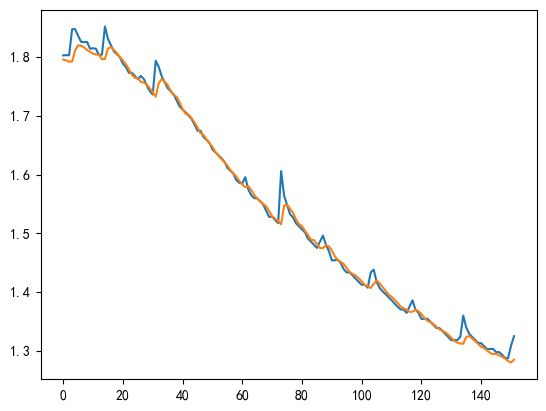

In [17]:
def train(model, train_dataloader, loss_fn, optimizer, epoch):
    model.train()
    for idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device).reshape(-1, 1)
        pred = model(X)
        loss = loss_fn(y, pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

model = TSCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001)

train_dataset = b6 + b7
test_dataset = b5
train_dataset = BatteryDataset(train_dataset)
test_dataset = BatteryDataset(test_dataset)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

epochs = 4000
print("训练开始")
for epoch in range(epochs):
    train(model, train_dataloader, criterion, optimizer, epoch)
print("训练完成")

y_pred, gt, y1, y2 = [], [], [], []
model.eval()
for idx, (X, y) in enumerate(test_dataset):
    X = X.to(device)
    y_pred.append(float(model(X)))
    gt.append(y)

plt.plot(gt)
plt.plot(y_pred)

训练开始
训练完成


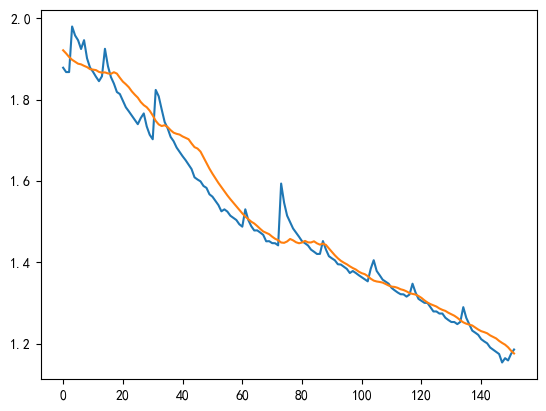

In [13]:
def train(model, train_dataloader, loss_fn, optimizer, epoch):
    model.train()
    for idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device).reshape(-1, 1)
        pred = model(X)
        loss = loss_fn(y, pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

model = TSCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001)

train_dataset = b5 + b7
test_dataset = b6
train_dataset = BatteryDataset(train_dataset)
test_dataset = BatteryDataset(test_dataset)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

epochs = 400
print("训练开始")
for epoch in range(epochs):
    train(model, train_dataloader, criterion, optimizer, epoch)
print("训练完成")

y_pred, gt, y1, y2 = [], [], [], []
model.eval()
for idx, (X, y) in enumerate(test_dataset):
    X = X.to(device)
    y_pred.append(float(model(X)))
    gt.append(y)

plt.plot(gt)
plt.plot(y_pred)

训练开始
训练完成


/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


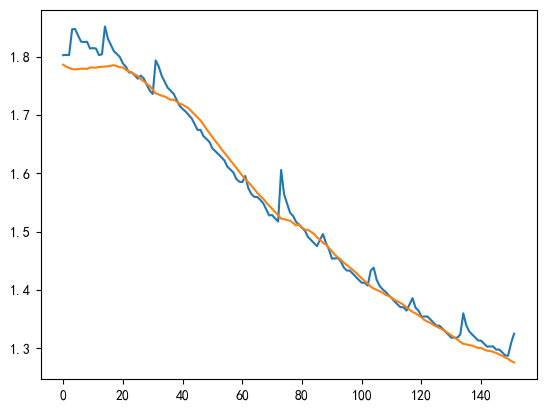

In [37]:
def train(model, train_dataloader, loss_fn, optimizer, epoch):
    model.train()
    for idx, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device).reshape(-1, 1)
        pred = model(X)
        loss = loss_fn(y, pred)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

model = TSCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.00001)

train_dataset = b5 + b6
test_dataset = b5
train_dataset = BatteryDataset(train_dataset)
test_dataset = BatteryDataset(test_dataset)

batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

epochs = 400
print("训练开始")
for epoch in range(epochs):
    train(model, train_dataloader, criterion, optimizer, epoch)
print("训练完成")

y_pred, gt, y1, y2 = [], [], [], []
model.eval()
for idx, (X, y) in enumerate(test_dataset):
    X = X.to(device)
    y_pred.append(float(model(X)))
    gt.append(y)

plt.plot(gt)
plt.plot(y_pred)